## Trend Example 1

In [1]:
# add quantkit to path
import sys
from pathlib import Path

d = Path().resolve().parent.parent
sys.path.insert(0, str(d))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import quantkit.bt as bt
import quantkit.bt.frequency as frequency
import quantkit.bt.signals as signals
import quantkit.bt.portfolio_management as portfolio_management
import quantkit.bt.risk_management as risk_management
import quantkit.bt.weighting_schemes as weighting_schemes
import quantkit.bt.technical_analysis as technical_analysis
import quantkit.bt.util as util

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

### Create fake data

In [3]:
rf = 0.04
np.random.seed(1)
mus = np.random.normal(loc=0.05, scale=0.02, size=5) + rf
sigmas = (mus - rf) / 0.3 + np.random.normal(loc=0.0, scale=0.01, size=5)

num_years = 10
num_months_per_year = 12
num_days_per_month = 21
num_days_per_year = num_months_per_year * num_days_per_month

rdf = pd.DataFrame(
    index=pd.date_range(
        start="2008-01-02",
        periods=num_years * num_months_per_year * num_days_per_month,
        freq="B",
    ),
    columns=["foo", "bar", "baz", "fake1", "fake2"],
)

for i, mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:, i] = np.random.normal(
        loc=mu / num_days_per_year,
        scale=sigma / np.sqrt(num_days_per_year),
        size=rdf.shape[0],
    )
pdf = np.cumprod(1 + rdf) * 100

### Create Trend signal over the last 12 months

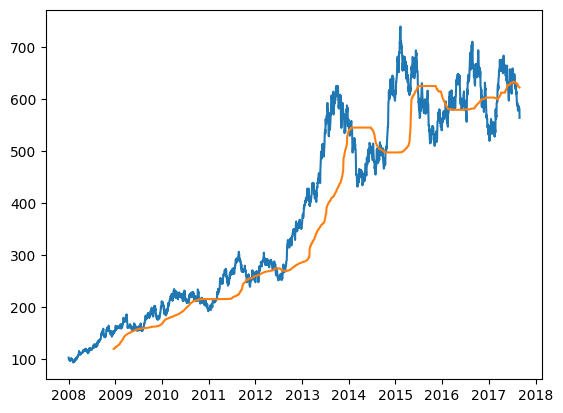

In [4]:
sma = pdf.rolling(window=num_days_per_month * 12, center=False).median().shift(1)
plt.plot(pdf.index, pdf["foo"])
plt.plot(sma.index, sma["foo"])
plt.show()

In [5]:
# target weights
trend = sma.copy()
trend[pdf > sma] = True
trend[pdf <= sma] = False
trend[sma.isnull()] = False

Compare EW and 1/vol

Both strategies rebalance daily using trend with 1 day lag and weights limited to 40%.

In [6]:
children = [bt.Security(name) for name in trend.columns]

tsmom_invvol_strat = bt.Strategy(
    "tsmom_invvol",
    algos=[
        frequency.RunDaily(),
        signals.SelectWhere(trend),
        weighting_schemes.InvVolWeight(),
        portfolio_management.Rebalance(),
    ],
    children=children,
)

tsmom_ew_strat = bt.Strategy(
    "tsmom_ew",
    algos=[
        frequency.RunDaily(),
        signals.SelectWhere(trend),
        weighting_schemes.EqualWeight(),
        portfolio_management.Rebalance(),
    ],
    children=children,
)

In [7]:
import quantkit.bt.portfolio_management.comission_functions as comission_functions

# create and run
tsmom_invvol_bt = bt.Backtest(
    tsmom_invvol_strat,
    pdf,
    initial_capital=50000000.0,
    commissions=comission_functions.quantity_comm_fn,
    integer_positions=False,
)

tsmom_ew_bt = bt.Backtest(
    tsmom_ew_strat,
    pdf,
    initial_capital=50000000.0,
    commissions=comission_functions.quantity_comm_fn,
    integer_positions=False,
)

res = bt.run(tsmom_ew_bt, tsmom_invvol_bt)

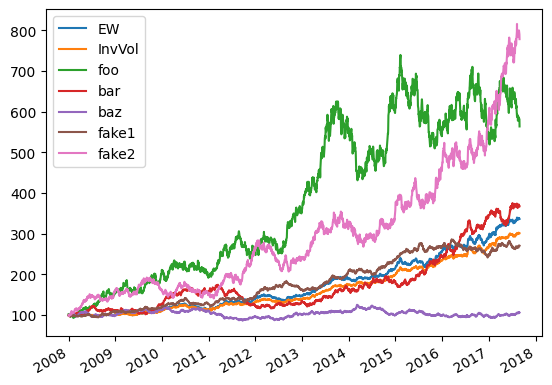

In [8]:
ax = plt.subplot()
ax.plot(res["tsmom_ew"].prices.index, res["tsmom_ew"].prices, label="EW")
ax.plot(res["tsmom_invvol"].prices.index, res["tsmom_invvol"].prices, label="InvVol")
pdf.plot(ax=ax)

ax.legend()
plt.legend()
plt.show()

In [9]:
res.display()

Stat                 tsmom_ew    tsmom_invvol
-------------------  ----------  --------------
Start                2008-01-01  2008-01-01
End                  2017-08-29  2017-08-29
Risk-free rate       0.00%       0.00%

Total Return         236.30%     201.03%
Daily Sharpe         1.34        1.41
Daily Sortino        2.33        2.47
CAGR                 13.38%      12.09%
Max Drawdown         -13.50%     -12.11%
Calmar Ratio         0.99        1.00

MTD                  1.75%       1.83%
3m                   4.07%       3.19%
6m                   8.34%       6.71%
YTD                  14.88%      11.92%
1Y                   20.37%      18.30%
3Y (ann.)            19.35%      17.83%
5Y (ann.)            19.48%      17.65%
10Y (ann.)           -           -
Since Incep. (ann.)  13.38%      12.09%

Daily Sharpe         1.34        1.41
Daily Sortino        2.33        2.47
Daily Mean (ann.)    12.57%      11.35%
Daily Vol (ann.)     9.36%       8.05%
Daily Skew           -0.04       